# CODE FOR GROUP 8
### Group members: Leonardo AVONI; Lukas STUBER; Alexander STEPHAN

In order for the code to work, it must be placed on a folder along with the following elements:


    -A folder named "Data_images", containing the 10'000x10'000 images used initially. In our case, the folder contains the following images:
        -swissimage-dop10_2022_2682-1249_0.1_2056.tif
        -swissimage-dop10_2022_2686-1252_0.1_2056.tif
        
    -A folder named "Groundtruths", containing the 10'000x10'000 gt-images created using the click_pixel.py code, using the images contained in folder "Data_images". In our case, the folder contains the following images:
        -groundtruth_swissimage-dop10_2022_2682-1249_0.1_2056
        -groundtruth_swissimage-dop10_2022_2686-1252_0.1_2056
    
    -A folder named "Segmentation", containing the 10'000x10'000 segmentation-images created after using the click_pixel.py code, using the images contained in folder "Data_images". In our case, the folder contains the following images:
        -swissimage-dop10_2022_2682-1249_0.1_2056.tif_Segmentation
        -swissimage-dop10_2022_2686-1252_0.1_2056.tif_Segmentation
        
    -A folder named "Buffer_folder", used to save images created during the code operation (initially, the folder is empty)
    
    -A folder named "Features", used to save the features data created during the code operation (initially, the folder is empty)
    
    -A folder named "Predictions", used to save the prediction images, obtained after we use the classifier on the images from the Buffer_folder
    
The pipeline of the code is explained in the report

## Installing dependancies (if needed)

In [1]:
!pip install -q pillow matplotlib scikit-image scikit-learn gdown
!pip install joblib

## Various packages imports
Instead of importing the packages at each block, we decided to import them all at the very beginning

In [2]:
import zipfile
import gdown
import os
import tifffile as tiff 
import numpy as np
import time
import sys

import matplotlib.pyplot as plt # for plotting
from skimage.io import imsave, imread # to read and save images
from skimage.segmentation import mark_boundaries

from tqdm.auto import tqdm # progress bar
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import joblib

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_sta

## Start Timer
In order to evaluate the time taken by the code to run, we start a timer at the beginning

In [3]:
tic = time.time()
print(tic)

1673792569.4818149


# First part: the Introduction

## Listing and opening the images we are working on

We will start by listing the images used. Not only the images in folder "Data_images", but also the correspondant Groundtruths in folder "Groundtruths", and the segmentations in folder "Segmentation"

In [4]:
images_list = os.listdir("Data_images")
GT_list = os.listdir("Groundtruths")
Segmentation= os.listdir("Segmentation")

print("IMAGES USED:")
for image_filename in images_list:
    print("\tData_images/"+image_filename)
print("CORRESPONDING GT's:")
for image_filename in GT_list:
    print("\tGroundtruths/"+image_filename)
print("CORRESPONDING SEGMENTATIONS:")
for image_filename in Segmentation:
    print("\tSegmentation/"+image_filename)

IMAGES USED:
	Data_images/swissimage-dop10_2022_2682-1249_0.1_2056.tif
	Data_images/swissimage-dop10_2022_2686-1252_0.1_2056.tif
CORRESPONDING GT's:
	Groundtruths/groundtruth_swissimage-dop10_2022_2682-1249_0.1_2056.tif
	Groundtruths/groundtruth_swissimage-dop10_2022_2686-1252_0.1_2056.tif
CORRESPONDING SEGMENTATIONS:
	Segmentation/swissimage-dop10_2022_2682-1249_0.1_2056.tif_Segmentation.tif
	Segmentation/swissimage-dop10_2022_2686-1252_0.1_2056.tif_Segmentation.tif


Since the names of the images have been based on the numbers previously associated to the images, the images, GT's and segmentations are in good order. Hence we can associate images_list[k] with GT_list[k] and Segmentation[k]

NOTE: the software only works if the same number of pictures is present in all the folders. Also, the software does not check if the pictures entered as training, GT and segmentation are actually compatible (by number of pixels...), so that must be done by the user by looking at the pictures name

Now, we may want to check what all the 10'000x10'000 images look like. To do so, we show the pictures below (full images, not cropped)

Data_images/swissimage-dop10_2022_2682-1249_0.1_2056.tif

Data_images/swissimage-dop10_2022_2686-1252_0.1_2056.tif



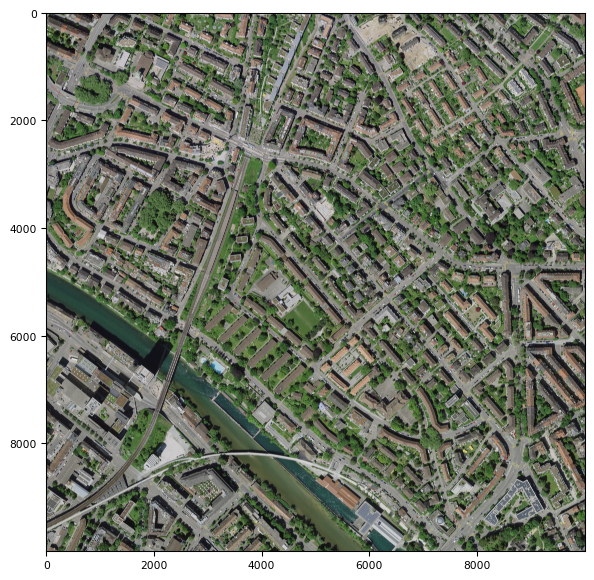

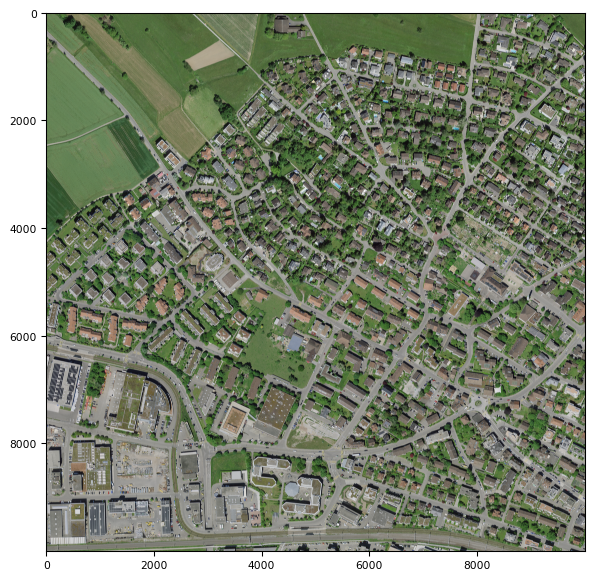

In [5]:
for image_filename in images_list:
    print("Data_images/"+image_filename+"\n")
    A=tiff.imread("Data_images/"+image_filename)
    tiff.imshow(A)

We also define some functions, like the crop_image_array function, needed later

In [6]:
def crop_image_array(image_array, y_min, y_max, x_min, x_max):
    """
    y_min is the starting row
    y_max is the ending row
    x_min is the starting colummn
    x_max is the ending colummn   
    
    """ 
    return image_array[y_min:y_max+1, x_min:x_max+1]

def plot_image_with_segmentation_and_gt(image,gt,segmentation):
    fig, axs = plt.subplots(1,2, figsize=(20,20))

    ax = axs[0]
    ax.imshow(image)

    ax = axs[1]

    ax.imshow(mark_boundaries(gt*230, segmentation))

## Defining the sub-images used for the analysis

This part serves the purpose of defining (using the images in folder "Data_images", "Groundtruths" and "Segmentation") the sub-images used for Training, Validation and Testing. For each image in "Data_images", we will define three sub-images: one for Training, one for Validation, one for Testing

Each sub-image is saved in the Buffer folder under the following name:

    -nameoftheinitialimage-y_min_y_max_x_min_x_max (for the image)
    -nameoftheinitialimage-y_min_y_max_x_min_x_maxgt (for the groundtruth)
    -nameoftheinitialimage-y_min_y_max_x_min_x_maxsegmetation (for the segmentation)
    
One example of a saved sub-image is: "swissimage-dop10_2022_2682-1249_0.1_2056-1500_1999_3250_4249.tif"

To understand which images are part of Training, Testing and Validation, we use list of names:

    -NAMES_OF_ALL_THE_TRAINING_IMAGES lists the names of the sub-images used for training
    -NAMES_OF_ALL_THE_VALIDATION_IMAGES lists the names of the sub-images used for validation
    -NAMES_OF_ALL_THE_TESTING_IMAGES lists the names of the sub-images used for testing

The list of names only provides the name of the image. In order to obtain the name of the gt or of the segmentation, one has to append "gt.tif" or "segmentation.tif" to the name (and remove the previous ".tif" at the end of the name)

We first select the training images (the ones used to train the random forest classifier)

Then we select the validation images. Those images are used with the trained classifier in order to assess the accuracy of the classifier. They will also be used to get the accuracy of the classifier after each optimization cycle. However, they will not be used to obtain the final accuracy of the classifier  

Finally, we select the testing images, used in order to assess the final performance of the classifier

### IMPORTANT: for the moment, the cropping coordinates x_min, x_max, y_min, y_max are such that the small images dataset is used (takes 10minutes to run completely). If you want to use the mdeium image or the large image, refer to the coordinates indicated in the report. Those coordinates are also made into comments (first the medium coordinates, then the large coordinates)

TRAINING IMAGES CHOSEN
First image taken for training, from swissimage-dop10_2022_2682-1249_0.1_2056.tif
Second image taken for training, from swissimage-dop10_2022_2686-1252_0.1_2056.tif
['swissimage-dop10_2022_2682-1249_0.1_2056-4750_5249_4700_5699', 'swissimage-dop10_2022_2686-1252_0.1_2056-9000_9499_2150_3149'] 



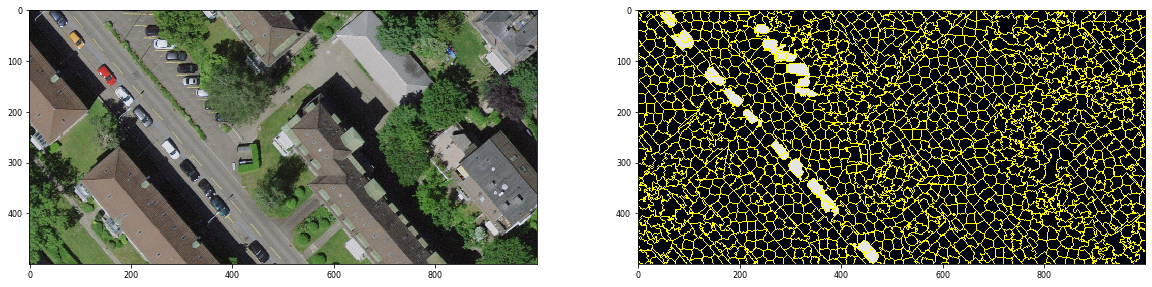

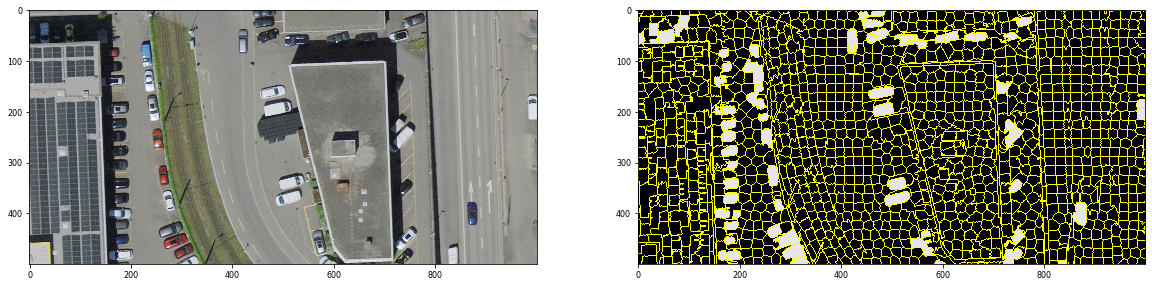

In [7]:

#for i in range(np.size(training_images_list)):
# FIRST IMAGE
print("TRAINING IMAGES CHOSEN")

i=0
print("First image taken for training, from",images_list[i])
y_min=4750 #4000 0
y_max=5249 #5999 9999
x_min=4700 #3000 0
x_max=5699 #6999 3199

image1_1 = tiff.imread("Data_images/"+images_list[i])
image1_1=crop_image_array(image1_1,y_min,y_max,x_min,x_max)
image2_1 = tiff.imread("Groundtruths/"+GT_list[i])
image2_1=crop_image_array(image2_1,y_min,y_max,x_min,x_max)
image3_1 = tiff.imread("Segmentation/"+Segmentation[i])
image3_1=crop_image_array(image3_1,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_1,image2_1,image3_1)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name1=images_list[i]
name1= name1.replace(".tif","-")
name1=name1+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
tiff.imsave("Buffer_folder/"+name1+".tif",image1_1)
tiff.imsave("Buffer_folder/"+name1+"gt.tif",image2_1)
tiff.imsave("Buffer_folder/"+name1+"segmentation.tif",image3_1)

i=1
print("Second image taken for training, from",images_list[i])
y_min=9000 #4000 0
y_max=9499 #5999 9999
x_min=2150 #3000 0
x_max=3149 #6999 3199
 
image1_2 = tiff.imread("Data_images/"+images_list[i])
image1_2=crop_image_array(image1_2,y_min,y_max,x_min,x_max)
image2_2 = tiff.imread("Groundtruths/"+GT_list[i])
image2_2=crop_image_array(image2_2,y_min,y_max,x_min,x_max)
image3_2 = tiff.imread("Segmentation/"+Segmentation[i])
image3_2=crop_image_array(image3_2,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_2,image2_2,image3_2)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name2=images_list[i]
name2= name2.replace(".tif","-")
name2=name2+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
#print(training_images_list)
tiff.imsave("Buffer_folder/"+name2+".tif",image1_2)
tiff.imsave("Buffer_folder/"+name2+"gt.tif",image2_2)
tiff.imsave("Buffer_folder/"+name2+"segmentation.tif",image3_2)

NAMES_OF_ALL_THE_TRAINING_IMAGES=[name1,name2]

print(NAMES_OF_ALL_THE_TRAINING_IMAGES,"\n")


VALIDATION IMAGES CHOSEN
First image taken for validation, from swissimage-dop10_2022_2682-1249_0.1_2056.tif
Second image taken for validation, from swissimage-dop10_2022_2686-1252_0.1_2056.tif
['swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699', 'swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999'] 



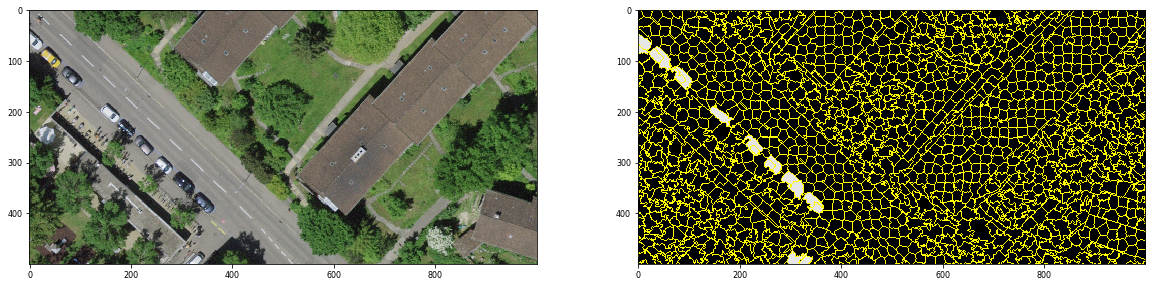

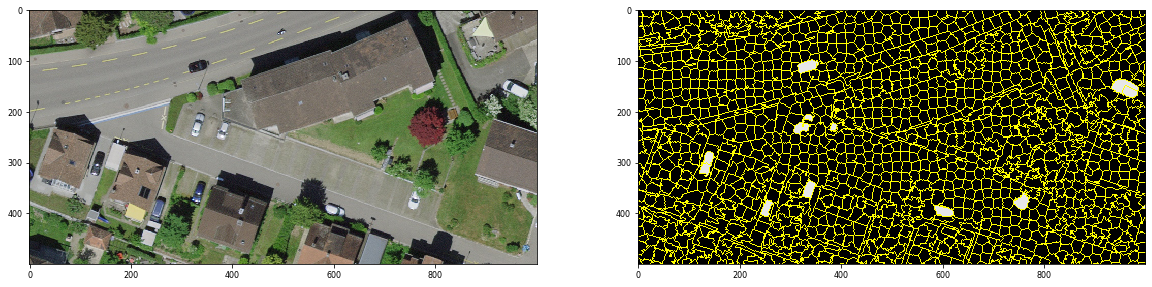

In [8]:

print("VALIDATION IMAGES CHOSEN")

i=0
print("First image taken for validation, from",images_list[i])
y_min=6700 #6000 0
y_max=7199 #7999 9999
x_min=3700 #2000 3200
x_max=4699 #5999 6399

image1_1 = tiff.imread("Data_images/"+images_list[i])
image1_1=crop_image_array(image1_1,y_min,y_max,x_min,x_max)
image2_1 = tiff.imread("Groundtruths/"+GT_list[i])
image2_1=crop_image_array(image2_1,y_min,y_max,x_min,x_max)
image3_1 = tiff.imread("Segmentation/"+Segmentation[i])
image3_1=crop_image_array(image3_1,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_1,image2_1,image3_1)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name1=images_list[i]
name1= name1.replace(".tif","-")
name1=name1+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
tiff.imsave("Buffer_folder/"+name1+".tif",image1_1)
tiff.imsave("Buffer_folder/"+name1+"gt.tif",image2_1)
tiff.imsave("Buffer_folder/"+name1+"segmentation.tif",image3_1)

i=1
print("Second image taken for validation, from",images_list[i])
y_min=8000 #8000 0
y_max=8499 #9999 9999
x_min=6000 #6000 3200
x_max=6999 #9999 6399

image1_2 = tiff.imread("Data_images/"+images_list[i])
image1_2=crop_image_array(image1_2,y_min,y_max,x_min,x_max)
image2_2 = tiff.imread("Groundtruths/"+GT_list[i])
image2_2=crop_image_array(image2_2,y_min,y_max,x_min,x_max)
image3_2 = tiff.imread("Segmentation/"+Segmentation[i])
image3_2=crop_image_array(image3_2,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_2,image2_2,image3_2)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name2=images_list[i]
name2= name2.replace(".tif","-")
name2=name2+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
#print(training_images_list)
tiff.imsave("Buffer_folder/"+name2+".tif",image1_2)
tiff.imsave("Buffer_folder/"+name2+"gt.tif",image2_2)
tiff.imsave("Buffer_folder/"+name2+"segmentation.tif",image3_2)

NAMES_OF_ALL_THE_VALIDATION_IMAGES=[name1,name2]

print(NAMES_OF_ALL_THE_VALIDATION_IMAGES,"\n")


TESTING IMAGES CHOSEN
First image taken for testing, from swissimage-dop10_2022_2682-1249_0.1_2056.tif
Second image taken for testing, from swissimage-dop10_2022_2686-1252_0.1_2056.tif
['swissimage-dop10_2022_2682-1249_0.1_2056-1500_1999_3250_4249', 'swissimage-dop10_2022_2686-1252_0.1_2056-4800_5299_3000_3999'] 



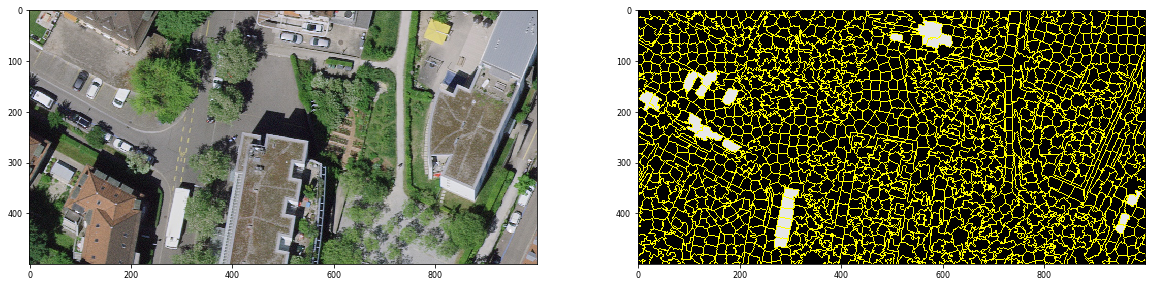

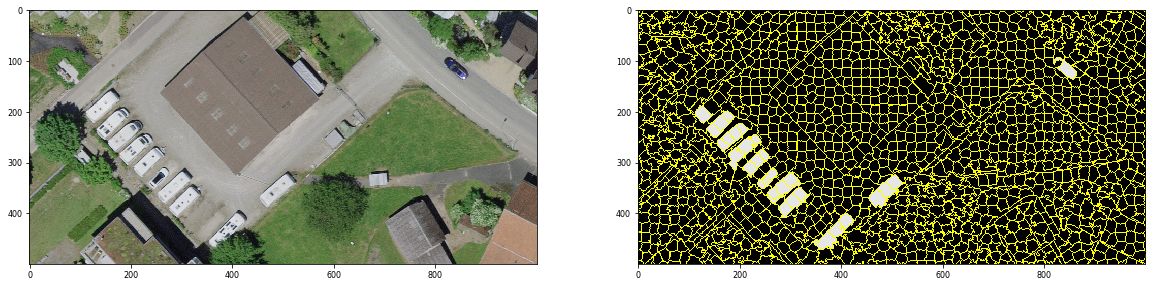

In [9]:
print("TESTING IMAGES CHOSEN")

i=0
print("First image taken for testing, from",images_list[i])
y_min=1500 #0    0
y_max=1999 #1999 9999
x_min=3250 #0    6400
x_max=4249 #3999 9599

image1_1 = tiff.imread("Data_images/"+images_list[i])
image1_1=crop_image_array(image1_1,y_min,y_max,x_min,x_max)
image2_1 = tiff.imread("Groundtruths/"+GT_list[i])
image2_1=crop_image_array(image2_1,y_min,y_max,x_min,x_max)
image3_1 = tiff.imread("Segmentation/"+Segmentation[i])
image3_1=crop_image_array(image3_1,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_1,image2_1,image3_1)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name1=images_list[i]
name1= name1.replace(".tif","-")
name1=name1+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
tiff.imsave("Buffer_folder/"+name1+".tif",image1_1)
tiff.imsave("Buffer_folder/"+name1+"gt.tif",image2_1)
tiff.imsave("Buffer_folder/"+name1+"segmentation.tif",image3_1)

i=1
print("Second image taken for testing, from",images_list[i])
y_min=4800 #5000 0
y_max=5299 #6999 9999
x_min=3000 #0    6400
x_max=3999 #3999 9599

image1_2 = tiff.imread("Data_images/"+images_list[i])
image1_2=crop_image_array(image1_2,y_min,y_max,x_min,x_max)
image2_2 = tiff.imread("Groundtruths/"+GT_list[i])
image2_2=crop_image_array(image2_2,y_min,y_max,x_min,x_max)
image3_2 = tiff.imread("Segmentation/"+Segmentation[i])
image3_2=crop_image_array(image3_2,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_2,image2_2,image3_2)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name2=images_list[i]
name2= name2.replace(".tif","-")
name2=name2+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
#print(training_images_list)
tiff.imsave("Buffer_folder/"+name2+".tif",image1_2)
tiff.imsave("Buffer_folder/"+name2+"gt.tif",image2_2)
tiff.imsave("Buffer_folder/"+name2+"segmentation.tif",image3_2)

NAMES_OF_ALL_THE_TESTING_IMAGES=[name1,name2]

print(NAMES_OF_ALL_THE_TESTING_IMAGES,"\n")

## Extracting the various features for each sub-image

The goal of the following blocks is to extract and save the features for each sub-image (the Training, the Validation and the Testing sub-images)

To do so, we will first define a group of functions useful to compute the various features. Those functions are:

    -convert_to_shape_pixels_by_bands: to convert 3-bands arrays to 1 band (loosing spatial information)
    -compute_average_feature: to compute the average for each band
    -compute_standard_deviation_feature: to compute the standard deviation for each band
    -compute_histogram_feature: to compute a 10-bins histogram for each band
    -number_of_pixels_per_region: to compute the number of pixels on the asked data
    
In order to create an array grouping all the features together for each region, we use the function compute_image_features_from_regions

In order to create an array describing which region has which label, we initially used get_label_per_region (does not work), but now we use get_label_per_region_V2 instead (works, but it becomes essential to have segmentations and gt's being created with the same SLIC method)

In order to actually compute and save the features, we use COMPUTE_NORM_FEATURE_and_eventually_labels. The function has been built in order to make label creation optional, in case we were to use brand new images, for whih we would just need to identify cars


In [10]:

def convert_to_shape_pixels_by_bands(data):
    """
    For a multiband image, the spatial information gets lost:
    a normal image has for example a shape of (500, 500, 3)
    the returned image has a shape of (250000, 3)
    
    """
    num_dimensions = len(np.shape(data))
    assert(num_dimensions == 2 or num_dimensions == 3)
    if num_dimensions == 3:
        num_bands = data.shape[2]
        return data.reshape((-1, num_bands))
    else:
        return data

def compute_average_feature(data):
    """
    the function returns a line vector with as much colummns as the number of bands. each col is the average for each band
    entering a 200x3 data array leads to a 1x3 array being returned 
    """
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Get the number of bands
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        # Compute the average value of each band (use the function np.mean)
        avg_features[b] = np.mean(data_2d[:, b])
    return avg_features

def compute_standard_deviation_feature(data):
    """
    same as "compute_average_feature", but it computes the std instead of the average
    entering a 200x3 data array leads to a 1x3 array being returned 
    """
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Compute the standard deviation feature (using the numpy function np.std)
    #       as in the function compute_average_feature iterate over the bands
    #       and compute one value for each band
    num_bands = data_2d.shape[1]
    std_features = np.zeros(num_bands)
    for b in range(num_bands):
        std_features[b] = np.std(data_2d[:, b])
    return std_features

def compute_histogram_feature(data, num_bins=10):
    """   
    For each band of "data", the 10-bins histogram is calculated. At the end, the various histograms are concatenated
    entering a 200x3 data array leads to a 1x30 array being returned 
    """
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_bands = data_2d.shape[1]
    hist_features = np.zeros((num_bands, num_bins)).astype(np.float32)
    for b in range(num_bands):
        # Compute the histogram for each band 
        #       use the function np.histogram(array, bins=num_bins)
        hist, boundaries = np.histogram(data_2d[:, b], bins=num_bins)
        hist_features[b, :] = hist
    # Return a 1D array containing all the values
    return hist_features.flatten()

def number_of_pixels_per_region(data):
    """
    Computes the number of pixel of a certain region "data". If data is a 200x3 array, num_pixels=200
    """
    
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_pixels = data_2d.shape[0]
    num_pixels=np.array([num_pixels])
    return num_pixels

def compute_image_features_from_regions(image, segmentation_map):
    """
    Return a matrix n_regions_in_the_image*n_features_per_region, corresponding to the features of the image. 
    Basically, the function computes for each region the corresponding features, then stacks vertically the features, in order to have the features for all the image
    """
    
    region_identifier_list=np.unique(segmentation_map) # list of all the regions in segmentation_map
    all_features = []
    
    for id_region in region_identifier_list: #region_identifier_list
        pixel_values = image[segmentation_map==id_region] 
        
        avg = compute_average_feature(pixel_values)
        std = compute_standard_deviation_feature(pixel_values)
        hist_features = compute_histogram_feature(pixel_values)
        numb_pixels = number_of_pixels_per_region(pixel_values)
        
        features = np.concatenate([avg, std, numb_pixels, hist_features])

        all_features.append(features)
    # convert list to numpy array of shape: (num_regions x num_bands)
    return np.array(all_features).astype(np.float32)

def get_label_per_region(segmented_image, label_map):
    """
    Returns a 1D numpy array that contains the label for each region, shape: (num_regions)
            For each region, we obtain the label that has the largest intersection with it
    """    
    REGION_LIST = np.unique(segmented_image)
    num_labels = len(np.unique(label_map))
    region_labels = []
    for region_id in REGION_LIST:
        mask_region = segmented_image == region_id
        intersection_per_label = []
        for label_id in range(num_labels):
            mask_label = label_map == label_id
            # Compute intersection of each region with each label
            intersection = np.sum(mask_region * mask_label)
            intersection_per_label.append(intersection)
        
        intersection_per_label = np.array(intersection_per_label)
        # Obtain the index of the label with largest intersection
        selected_label = np.argmax(intersection_per_label)
        region_labels.append(selected_label)
    return np.array(region_labels).astype(np.uint32)

def get_label_per_region_V2(segmented_image,label_map):
    """
    Returns a 1D numpy array that contains the label for each region, shape: (num_regions)
            We do not rely on the maximum intersection to determine the label of a certain region. We suppose compatibility between the label_map (GT) and the segmented_image
            The function only works for our scenario, where label can take only 0 or 1 values
    """    
    REGION_LIST = np.unique(segmented_image)
    region_labels=np.zeros(np.shape(REGION_LIST))
    for region_id in REGION_LIST:
        mask_region = segmented_image == region_id
        test=np.sum(mask_region * label_map)
        if test !=0:
            index=np.where(REGION_LIST==region_id)
            region_labels[index]=1
    return region_labels

def COMPUTE_NORM_FEATURE_and_eventually_labels(path_where_the_images_are_located,list_of_images,width_square,height_square,fast,compute_labels):
    
    """
    This function does the following thing:
        
        It takes the images from "path_where_the_images_are_located", described by "list_of_images"
        
        Each image is decomposed in sub-rectangular patches of width "width_square" and height "height_square". 
        When using the function, it is imperative to choose those two parameters in order to be able to process the full image, without any leftouts
        
        During this process:
            
            For each image
                
                The features are computed
                The features are normalized
                (the labels are computed, if required)
            
            The features are concatenated
            (the labels are concatenated, if required)
        
        The function outputs the concatenated features (and eventually the labels)
        
    There is an option to reduce computational time and just compute one of the patches per image, 
    instead of the total (merely for debugging)
    
    """
    
    
    all_image_region_features = []
    all_image_region_labels = []
    for image_name in list_of_images:
        features_per_image=[]
        
        image_used_cropped=tiff.imread(path_where_the_images_are_located+"/"+image_name+".tif")
        if compute_labels is not 0:
            image_used_cropped_gt=tiff.imread(path_where_the_images_are_located+"/"+image_name+"gt.tif")
        image_used_cropped_segmentation=tiff.imread(path_where_the_images_are_located+"/"+image_name+"segmentation.tif")

        if fast==0:
            for i in range(int(image_used_cropped.shape[0]/height_square)): 
                for j in range (int(image_used_cropped.shape[1]/width_square)):
                    print("Currently on square ",i,j,"Image",image_name)
                    image=crop_image_array(image_used_cropped,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)    
                    image_segmentation=crop_image_array(image_used_cropped_segmentation,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)

                    region_features = compute_image_features_from_regions(image,image_segmentation)
                    features_per_image.append(region_features)
                    
                    if compute_labels is not 0:
                        image_gt=crop_image_array(image_used_cropped_gt,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)
                        region_labels = get_label_per_region_V2(image_segmentation, image_gt)
                        all_image_region_labels.append(region_labels)
                    #print(region_features.shape)
        if fast is not 0:
            for i in range(1): # REPLACE 1 with int(image_used_cropped.shape[0]/height_square) in order to analyze all the squares
                for j in range (1): # REPLACE 1 with int(image_used_cropped.shape[1]/width_square) in order to analyze all the squares
                    print("Currently on square ",i,j,"Image",image_name)
                    image=crop_image_array(image_used_cropped,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)    
                    image_segmentation=crop_image_array(image_used_cropped_segmentation,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)

                    region_features = compute_image_features_from_regions(image,image_segmentation)
                    features_per_image.append(region_features)
                    
                    if compute_labels is not 0:
                        image_gt=crop_image_array(image_used_cropped_gt,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)
                        region_labels = get_label_per_region_V2(image_segmentation, image_gt)
                        all_image_region_labels.append(region_labels)
                    #print(region_features.shape)                   
        
        features_per_image=np.concatenate(features_per_image)
        
        mean_per_image = np.mean(features_per_image, axis=0)
        std_per_image = np.std(features_per_image, axis=0)
        norm_features_per_image = (features_per_image-mean_per_image)/std_per_image
        
        np.save("Features/norm_image_features_"+image_name+".npy",norm_features_per_image)
        
        all_image_region_features.append(norm_features_per_image)
       
    # Tranforming the list all_train_region_labels in an array of shape: (num_all_regions)
    images_labels = np.concatenate(all_image_region_labels)
    print("Multi image label shape " + str(images_labels.shape))
    # Tranforming the list all_train_region_features in an array of shape: (num_all_regions, num_features)
    norm_images_features = np.concatenate(all_image_region_features)
    print("Multi image features shape " + str(norm_images_features.shape))
    
    return norm_images_features,images_labels

When doing the analysis, we realized that analyzing directly the images saved in the folder Buffer_folder using the compute_image_features_from_regions function, would need a certain amount of time depending on the zize of the images.

It turns out that the feature calculation method:

    -takes 0.019s for a 100*100 image
    -takes 0.056s for a 200*200 image
    -takes 0.260s for a 400*400 image
    -takes 0.450s for a 500*500 image
    -takes 4s for a 800*800 image
    -takes 6.250s for a 1000*1000 image
    -takes ~488s for a 2000*4000 image

For reasons of timing in computing the various images, we will sub-segment each sub-image in smaller rectangular patches, as is done in function "COMPUTE_NORM_FEATURE_and_eventually_labels". 

Now that the function has been defined, we can produce the train_labels and train_features needed to train the classifier:

Since we are already there, we also compute the features for the validation, and for testing (the features are saved in the "Features" folder)


In [11]:
width_square=500 #500
height_square=500 #500

train_features,train_labels=COMPUTE_NORM_FEATURE_and_eventually_labels("Buffer_folder",NAMES_OF_ALL_THE_TRAINING_IMAGES,width_square,height_square,0,1)

A,B=COMPUTE_NORM_FEATURE_and_eventually_labels("Buffer_folder",NAMES_OF_ALL_THE_VALIDATION_IMAGES,width_square,height_square,0,1)
A,B=COMPUTE_NORM_FEATURE_and_eventually_labels("Buffer_folder",NAMES_OF_ALL_THE_TESTING_IMAGES,width_square,height_square,0,1)

# We do not need to store as python variables the features and labels, because the features are saved in the "Features" folder

Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-4750_5249_4700_5699
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-4750_5249_4700_5699
Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-9000_9499_2150_3149
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-9000_9499_2150_3149
Multi image label shape (2779,)
Multi image features shape (2779, 37)
Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699
Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999
Multi image label shape (2757,)
Multi image features shape (2757, 37)
Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-1500_1999_3250_4249
Currently on square  0 1 Image s

At the end of the previous block, we should end up with the matrix train_features, and the vector train_labels. Both can be directly used to train the classifier

## We train the classifier a first time
The first time we train the classifier, the classifier's parameters are set randomly.

In [19]:
classifier = RandomForestClassifier(random_state=10,min_samples_split=2,bootstrap=False) # the random_state line is redundant

classifier.fit(train_features,train_labels)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

## Predict the accuracy of the classifier

TO predict the accuracy of the classifier, we need to apply it to the validation dataset. However we need a function to provide the confusion matrix. This is the goal of the next function, that will compute the predictions, and the confusion matrix, based on the classifier, on the gt, on the segmentation...

The function that will do that is called predict_classification_maps_and_get_accuracy_V2


In [13]:
def predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier, path_where_the_images_are_located, image_names, save_predictions):
    """
    The goal of this function is to compute the confusion matrix for the images called by image_names, processed using the classifier
    
    To do so, the function does the following:
    
    For each image:
        the segmentation is loaded
        the features file is loaded
        the predictions for the features are computed using the features and the classifier
        
        then, the system rearranges the predictions to make them compatible with the groundtruth files
    then, the predictions are stacked, and compared with the stacked groundtruths
    
    At the end, the confusion matrix is obtained
    
    In order for the function to work, the patch dimensions (width_square,height_square) must be chosen accordingly, in order to cover competely the 
    image, with no zones left out. The same parameters used previously must be used
        
    The function returns the conf matrix and the producer accuracy for cars
    """

    list_predictions = []
    list_gt_labels = []
    
    for image_name in image_names:  

        segmented_image=tiff.imread(path_where_the_images_are_located+"/"+image_name+"segmentation.tif")
        norm_image_features = np.load("Features/norm_image_features_"+image_name+".npy") #features nell'ordine dei quadrati
        label_predictions = classifier.predict(norm_image_features) #labels nell'ordine dei quadrati
        # serve una corrispondenza tra l'ordine delle features e la regione in questione
        
        counter=0
        prediction_map=np.zeros(segmented_image.shape).astype(np.uint8)
        
        for i in range(int(segmented_image.shape[0]/height_square)): 
            for j in range (int(segmented_image.shape[1]/width_square)):
                print("Currently on square ",i,j,"Image",image_name)
                
                segmented_image_cropped=crop_image_array(segmented_image,i*height_square,(i+1)*height_square-1,j*width_square,(j+1)*width_square-1)
                prediction_map_cropped=np.zeros([height_square,width_square]).astype(np.uint8)
                
                REGIONS = np.unique(segmented_image_cropped)
                for region_id in REGIONS: 

                    matrix_index=np.where(REGIONS==region_id) #indexes relativi alla lista di regions nella matrice cropped
                    matrix_index=matrix_index[0].item()
                    
                    prediction_map_cropped[segmented_image_cropped==region_id] = label_predictions[matrix_index+counter]
                    
                counter=counter+REGIONS.size
                prediction_map[i*height_square:(i+1)*height_square, j*width_square:(j+1)*width_square]=prediction_map_cropped #associamo i valori di prediction alla vera map

        list_predictions.append(prediction_map.flatten())
        
        if save_predictions:
            imsave("Predictions/prediction_"+image_name+".tif", prediction_map)
            

        image_gt = tiff.imread(path_where_the_images_are_located+"/"+image_name+"gt.tif")
        list_gt_labels.append(image_gt.flatten())

    all_predictions = np.concatenate(list_predictions)
    all_gt_labels =np.concatenate(list_gt_labels) 

    #accuracy = accuracy_score(all_gt_labels, all_predictions)
    conf_matrix = confusion_matrix(all_gt_labels, all_predictions)
    producer_accuracy=conf_matrix[1,1]/(np.sum(conf_matrix[1,:]))        
    return producer_accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix):
    """
    This function only serves the purpose of plotting the confusion matrix
    
    """
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

Now we can use the functions "predict_classification_maps_and_get_accuracy_V2" and "plot_confusion_matrix" in order to get the prediction and confusion matrix

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


0.45895685021066396
[[979719   6515]
 [  7448   6318]]


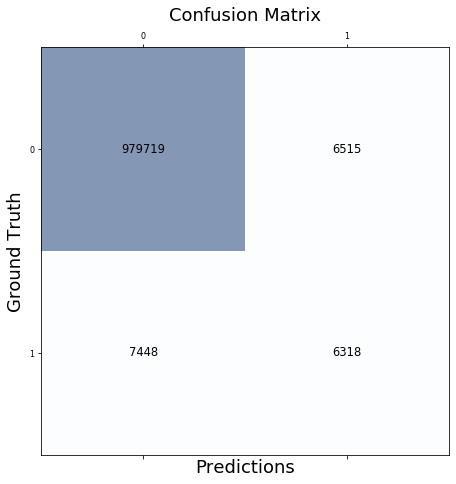

In [14]:
producer_accuracy,conf_matrix=predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier,"Buffer_folder",NAMES_OF_ALL_THE_VALIDATION_IMAGES,1)

print(producer_accuracy)
print(conf_matrix)

plot_confusion_matrix(conf_matrix)

Just to test if everything is ok, we will try to input the classifier with the training data (we should get 100% accuracy if everything is done correctly, unless the classifier has been built with bootstrap==True)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-4750_5249_4700_5699
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-4750_5249_4700_5699


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2682-1249_0.1_2056-4750_5249_4700_5699.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-9000_9499_2150_3149
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-9000_9499_2150_3149


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2686-1252_0.1_2056-9000_9499_2150_3149.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


1.0
[[956886      0]
 [     0  43114]]


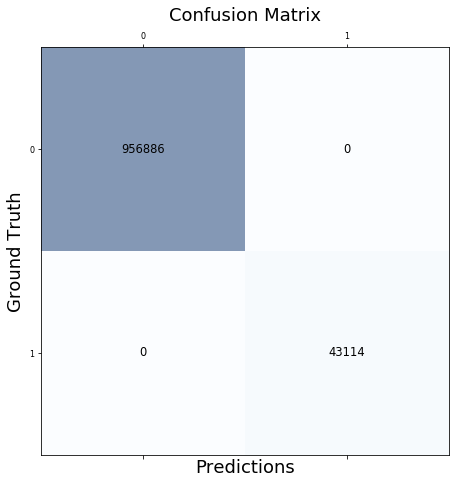

In [15]:
producer_accuracy,conf_matrix=predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier,"Buffer_folder",NAMES_OF_ALL_THE_TRAINING_IMAGES,1)

print(producer_accuracy)
print(conf_matrix)

plot_confusion_matrix(conf_matrix)

# Second part: the Optimization

Now that we have tested the various elements of the code until now, we can try to improve the performance of the classifier. Our optimization parameter will not be the overall accuracy, because of the low amount of cars in an image (we can reach very high overall accuracy even though cars are not well classified). We will instead use the Producer accuracy for the cars (number of car pixels classified as cars/number of car pixels). Just to show that the overall accuracy is not reliable, we will quickly compute the % of cars on the initial images. 

In [16]:
Percent_cars=0
N_images=np.shape(images_list)[0]
for image_name in images_list:
    image=tiff.imread("Groundtruths/groundtruth_"+image_name)
    N_pixels_per_image=np.product(np.shape(image))
    N_car_pixels_per_image=np.sum(image)
    Percent_cars=Percent_cars+N_car_pixels_per_image/N_pixels_per_image
Percent_cars=100*Percent_cars/N_images
print("The cars on the images used compose",Percent_cars," % of the images")

The cars on the images used compose 1.0653355  % of the images


As we can see, a very low % of the image is covered by cars, thus justifying again the use of the producer accuracy. In order to optimize the classifier, we will play with some of the random forest parameters:

    -n_estimators: number of trees in the forest
    -max_depth: maximum depth of the trees
    -bootstrap: do the treees use the full dataset or not?
    
Optimizing those parameters will help us avoid overfitting. More details about what the parameters do are provided in the report

The general idea of the following for-loops is to check what are the optimum parameters. If a set of parameters is better, it will lead to a higher producer accuracy, and thus will be kept.

In [17]:
# List of paramaters to evaluate in the validation set
n_estimators_values = [20, 50, 100, 200, 500, 1000] #number of trees
max_depth_values = [5, 10, 20, None] #tree depth
bootstrap_values=[True,False] #full dataset or not?

In [18]:
max_producer_accuracy=-1
optimal_estimator_value=[]
optimal_depth=[]
optimal_bootstrap=[]
optimal_producer_accuracy=[]
for x in n_estimators_values:
    for y in max_depth_values:
        for k in bootstrap_values:
        
            classifier = RandomForestClassifier(random_state=10, n_estimators=x, max_depth=y,bootstrap=k)
            classifier.fit(train_features,train_labels)

            producer_accuracy,conf_matrix=predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier,"Buffer_folder",NAMES_OF_ALL_THE_VALIDATION_IMAGES,1)

            if producer_accuracy>max_producer_accuracy:
                max_producer_accuracy=producer_accuracy
                optimal_estimator_value=x
                optimal_depth=y
                optimal_bootstrap=k
                optimal_producer_accuracy=producer_accuracy
            print("estimator",x,"depth",y,"producer accuracy",producer_accuracy,"\n")
classifier = RandomForestClassifier(random_state=10, n_estimators=optimal_estimator_value, max_depth=optimal_depth,bootstrap=optimal_bootstrap)
classifier.fit(train_features,train_labels)
print("The opt. estimator number is",optimal_estimator_value,", the opt.depth is",optimal_depth,"the optimal bootstrap is",optimal_bootstrap,"; allowing an opt. producer accuracy of",optimal_producer_accuracy,"\n")
        

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


estimator 20 depth 5 producer accuracy 0.25388638674996367 



C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2682-1249_0.1_2056-6700_7199_3700_4699.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-8000_8499_6000_6999


KeyboardInterrupt: 

In [ ]:
print("The opt. estimator number is",optimal_estimator_value,", the opt.depth is",optimal_depth,"the optimal bootstrap is",optimal_bootstrap,"; allowing an opt. producer accuracy of",optimal_producer_accuracy,"\n")

Now, we are going to save the classifier obtained, just to avoid training it again. The classifier is saved in the same directory as the jupyter notebooks code

In [21]:
joblib.dump(classifier, "small_images_classifier.joblib")

['small_images_classifier.joblib']

Let's check the confusion matrix obtained at the end of validation

In [ ]:
producer_accuracy,conf_matrix=predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier,"Buffer_folder",NAMES_OF_ALL_THE_VALIDATION_IMAGES,1)
print("The testing producer accuracy is",producer_accuracy)
plot_confusion_matrix(conf_matrix)

Now that the classifier has been trained, we will perform testing on the last set of images in order to really understand what the producer accuracy is. 

# Third part: the Results

In case you do not want to spend time optimizing the classifier, as long as the sub-images have been defined, and the features files have been created, it is possible to import the pre-trained classifier (only for the small image dataset), and use it. Basically, you can import the classifier if you run everything except for the "Second part: the Optimization"

The location of the classifier is:

    -ARCHIVE/Small_images/small_images_classifier.npy for the small images dataset

In [22]:
"""
classifier= joblib.load("ARCHIVE/Small_images/small_images_classifier.joblib")

"""


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2682-1249_0.1_2056-1500_1999_3250_4249
Currently on square  0 1 Image swissimage-dop10_2022_2682-1249_0.1_2056-1500_1999_3250_4249


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2682-1249_0.1_2056-1500_1999_3250_4249.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Currently on square  0 0 Image swissimage-dop10_2022_2686-1252_0.1_2056-4800_5299_3000_3999
Currently on square  0 1 Image swissimage-dop10_2022_2686-1252_0.1_2056-4800_5299_3000_3999


C:\Users\User\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: Predictions/prediction_swissimage-dop10_2022_2686-1252_0.1_2056-4800_5299_3000_3999.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


The testing producer accuracy is 0.494074621092239


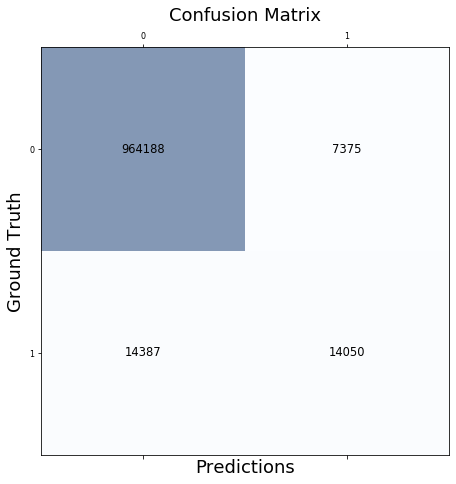

In [23]:
producer_accuracy,conf_matrix=predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier,"Buffer_folder",NAMES_OF_ALL_THE_TESTING_IMAGES,1)
print("The testing producer accuracy is",producer_accuracy)
plot_confusion_matrix(conf_matrix)

We will not only display the producer accuracy, and the confusion matrix. We will also display the initial images, as well as the original gt and the classifier prediction

In [ ]:
def plot_image_segmentation_gt_prediction(image,gt,segmentation,prediction):
    fig, axs = plt.subplots(1,3, figsize=(20,20))

    ax = axs[0]
    ax.imshow(image)

    ax = axs[1]

    ax.imshow(mark_boundaries(gt*230, segmentation))
    
    ax = axs[2]

    ax.imshow(mark_boundaries(prediction*230, segmentation))

In [ ]:
for image_name in NAMES_OF_ALL_THE_TESTING_IMAGES:
    image=tiff.imread("Buffer_folder/"+image_name+".tif")
    gt=tiff.imread("Buffer_folder/"+image_name+"gt.tif")
    segmentation=tiff.imread("Buffer_folder/"+image_name+"segmentation.tif")
    prediction=tiff.imread("Predictions/prediction_"+image_name+".tif")
    plot_image_segmentation_gt_prediction(image,gt,segmentation,prediction)

## Stop Timer

In [ ]:
toc = time.time()
print("The code took", (toc-tic)/60,"Minutes")

# Additional work


## Visualization (code run with large images)

The next three blocks were used when the code was run with the large set of images; in order to zoom in in the predictions and obtain the figures in the report

In [ ]:
def plot_image_final(image,prediction):
    tiff.imshow(mark_boundaries(image, prediction, color=(0.62, 0.12, 0.94), outline_color=(0.62, 0.12, 0.94), mode='outer', background_label=0))

In [ ]:
"""

image_name=NAMES_OF_ALL_THE_TESTING_IMAGES[0]

image=tiff.imread("Buffer_folder/"+image_name+".tif")
gt=tiff.imread("Buffer_folder/"+image_name+"gt.tif")
segmentation=tiff.imread("Buffer_folder/"+image_name+"segmentation.tif")
prediction=tiff.imread("Predictions/prediction_"+image_name+".tif")

y_min=8999
y_max=9999
x_min=250
x_max=1750

image=crop_image_array(image, y_min, y_max, x_min, x_max)
prediction=crop_image_array(prediction, y_min, y_max, x_min, x_max)

plot_image_final(image,prediction)


print(x_min,"_",x_max,"_",y_min,"_",y_max)

"""

In [ ]:
"""

image_name=NAMES_OF_ALL_THE_TESTING_IMAGES[1]

image=tiff.imread("Buffer_folder/"+image_name+".tif")
gt=tiff.imread("Buffer_folder/"+image_name+"gt.tif")
segmentation=tiff.imread("Buffer_folder/"+image_name+"segmentation.tif")
prediction=tiff.imread("Predictions/prediction_"+image_name+".tif")

y_min=8999
y_max=9999
x_min=1600
x_max=3100

image=crop_image_array(image, y_min, y_max, x_min, x_max)
prediction=crop_image_array(prediction, y_min, y_max, x_min, x_max)

plot_image_final(image,prediction)

print(x_min,"_",x_max,"_",y_min,"_",y_max)


"""

## Testing the classifier obtained for the small/medium images with other images (code run with small/medium images)

When running the classifier with small images, we noticed a relatively high producer accuracy, close to 50%. Compared to the 17% obtained with the large images, we had some questionings. We hence decided to use the classifier trained with the small images, to classify the testing set of the large images, and see the performance

In [ ]:
#for i in range(np.size(training_images_list)):
# FIRST IMAGE
print("TRAINING IMAGES CHOSEN")

i=1
print("First image taken for training, from",images_list[i])
y_min=0 
y_max=9999 
x_min=6400 
x_max=9599 

image1_1 = tiff.imread("Data_images/"+images_list[i])
image1_1=crop_image_array(image1_1,y_min,y_max,x_min,x_max)
image2_1 = tiff.imread("Groundtruths/"+GT_list[i])
image2_1=crop_image_array(image2_1,y_min,y_max,x_min,x_max)
image3_1 = tiff.imread("Segmentation/"+Segmentation[i])
image3_1=crop_image_array(image3_1,y_min,y_max,x_min,x_max)
plot_image_with_segmentation_and_gt(image1_1,image2_1,image3_1)

# SAVE THE CROPPED IMAGE IN THE BUFFER FOLDER
name1=images_list[i]
name1= name1.replace(".tif","-")
name1=name1+str(y_min)+"_"+str(y_max)+"_"+str(x_min)+"_"+str(x_max)
tiff.imsave("Buffer_folder/"+name1+".tif",image1_1)
tiff.imsave("Buffer_folder/"+name1+"gt.tif",image2_1)
tiff.imsave("Buffer_folder/"+name1+"segmentation.tif",image3_1)


CHECKING_IMAGE=[name1]


In [ ]:
width_square=400
height_square=400

A,B=COMPUTE_NORM_FEATURE_and_eventually_labels("Buffer_folder",CHECKING_IMAGE,width_square,height_square,0,1)

In [ ]:
producer_accuracy,conf_matrix=predict_classification_maps_and_get_accuracy_V2(width_square,height_square,classifier,"Buffer_folder",CHECKING_IMAGE,1)

print(producer_accuracy)
print(conf_matrix)

plot_confusion_matrix(conf_matrix)